### Introduction/Summary

#### Problem Statement

What factors determine a high-rating for a movie? This analysis investigated the features of what makes a good movie (high rating). Since the access rights to movies do cost companies like Netflix, it is important that they select movies that their users want to watch, otherwise, they might shift to competitors.

The intent is to use features from IMDB api to evaluate the movie's rating. For this portion, top 250 movies will be used to determine feature importance and its predicting power using tree-based models, such as Decision Trees, Random Trees, and Extra Trees.

Sections in this notebook are:

1) Collecting Data

2) Tidying Data

3) Setting features and target

4) Visualization

5) Modeling



In [1466]:
import pandas as pd
import numpy as np
from imdbpie import Imdb
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,roc_curve, auc,roc_auc_score


### Collecting Data

Initializing the imdbpie to get top 250 movies. Taking the output and forming a DataFrame

In [2]:
from imdbpie import Imdb
imdb = Imdb()
imdb = Imdb(anonymize=True)

In [4]:
output = json.dumps(imdb.top_250())
top250 = pd.read_json(output)
top250.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1721841,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1176757,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'https://images-na.ssl-images-amazon...,806604,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'https://images-na.ssl-images-amazon...,1707654,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'https://images-na.ssl-images-amazon...,458835,8.9,tt0050083,12 Angry Men,feature,1957


In [6]:
# for y in top250['tconst']:
#     title = imdb.get_title_by_id(str(y))
#     print title.genres

Pulling more information from imdbpie to add it to the top250 dataframe

In [7]:
imdb_id = []
genres = []
runtime = []
certification = []
director = []
cast = []
release_date = []
writers = []
for y in top250['tconst']:
    title = imdb.get_title_by_id(str(y))
    imdb_id.append(title.imdb_id)
    genres.append(title.genres)
    cast.append(title.cast_summary)
    runtime.append(title.runtime)
    certification.append(title.certification)
    director.append(title.directors_summary)
    release_date.append(title.release_date)
    writers.append(title.writers_summary)

In [1008]:
# release_date = []
# writers = []
# for y in top250['tconst']:
#     title = imdb.get_title_by_id(str(y))
#     release_date.append(title.release_date)
#     writers.append(title.writers_summary)

Tidying up release date to extract month from release date

In [738]:
top250['release_date'] = release_date

In [739]:
release_month = []
for x in release_date:
    if len(x.split('-'))==3:
        #print x.split('-')[1]
        release_month.append(x.split('-')[1])
    elif len(x.split('-'))==2:
        #print x.split('-')[1]
        release_month.append(x.split('-')[1])
    else:
        #print 0
        release_month.append(0)
#release_month

In [743]:
top250['release_month'] = release_month
top250['release_month'] = top250['release_month'].apply(lambda x: int(x))

Adding the pulled data into the top250 dataframe

In [8]:
#top250['imdb_id'] = pd.Series(imdb_id)
top250['genres'] = pd.Series(genres)
top250['runtime'] = pd.Series(runtime)
top250['certification'] = pd.Series(certification)
top250['director'] = pd.Series(director)
top250['cast'] = pd.Series(cast)
top250['runtime'] = top250['runtime'].apply(lambda x: x/(60))

In [1732]:
top250.head()

,can_rate,image,num_votes,rating,tconst,title,type,year,genres,runtime,...,release_month,director_1,director_2,director_3,top_director,not_top_director,top_actors,mid_actors,bottom_actors,big_budget
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1721841,9.3,tt0111161,The Shawshank Redemption,feature,1994,"[Crime, Drama]",142,...,10,Frank Darabont,,Frank Darabont,0,1,0,0,3,0
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1176757,9.2,tt0068646,The Godfather,feature,1972,"[Crime, Drama]",175,...,3,Francis Ford Coppola,,Francis Ford Coppola,0,1,1,2,1,0
2,True,{u'url': u'https://images-na.ssl-images-amazon...,806604,9.0,tt0071562,The Godfather: Part II,feature,1974,"[Crime, Drama]",202,...,12,Francis Ford Coppola,,Francis Ford Coppola,0,1,2,2,0,0
3,True,{u'url': u'https://images-na.ssl-images-amazon...,1707654,9.0,tt0468569,The Dark Knight,feature,2008,"[Action, Crime, Drama, Thriller]",152,...,7,Christopher Nolan,,Christopher Nolan,1,0,0,1,2,1
4,True,{u'url': u'https://images-na.ssl-images-amazon...,458835,8.9,tt0050083,12 Angry Men,feature,1957,"[Crime, Drama]",96,...,4,Sidney Lumet,,Sidney Lumet,0,1,0,2,2,0


Scraping IMDB via Beautiful Soup to get Budget and Production Company Information

In [12]:
import requests
from bs4 import BeautifulSoup

In [1692]:
r = requests.get('http://www.imdb.com/title/tt0111161/')

In [1693]:
soup = BeautifulSoup(r.text, "html")
print soup.prettify()

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="app-id=342792525, app-argument=imdb:///title/tt0111161?src=mdot" name="apple-itunes-app"/>
  <script type="text/javascript">
   var ue_t0=window.ue_t0||+new Date();
  </script>
  <script type="text/javascript">
   var ue_mid = "A1EVAM02EL8SFB"; 
                var ue_sn = "www.imdb.com";  
                var ue_furl = "fls-na.amazon.com";
                var ue_sid = "000-0000000-0000000";
                var ue_id = "0MWP836XCN0H5WBT20KW";
                (function(e){var c=e;var a=c.ue||{};a.main_scope="mainscopecsm";a.q=[];a.t0=c.ue_t0||+new Date();a.d=g;function g(h){return +new Date()-(h?0:a.t0)}function d(h){return function(){a.q.push({n:h,a:arguments,t:a.d()})}}function b(m,l,h,j,i){var k={m:m,f:l,l:h,c:""+j,err:i,fromOnError:1,args:arguments};c.ueLogError(k);return false}b.s

In [1806]:
temp1=[]
temp2=[]
for c in soup.findAll('span',{"class":"itemprop","itemprop":"name"}):
    temp1.append(c.text)
temp2.append((temp1[-1]))
for x in temp2:
    print x

Castle Rock Entertainment


In [1807]:
prodco = []
prodco1 = []
prodco2 = []
def get_prodco(id_num):
    r = requests.get('http://www.imdb.com/title/'+id_num+'/')
    soup = BeautifulSoup(r.text, "html")
    for c in soup.findAll('span',{"class":"itemprop","itemprop":"name"}):
        prodco.append(c.text)
    prodco1.append((prodco[-1]))
    for x in prodco1:
        prodco2.append(x)
    return prodco2



In [1808]:
for x in top250['tconst']:
    prod_temp.append(get_prodco(str(x)))

#### Extracting the Budget data

In [1680]:
budget = []
gross = []
for d in soup.findAll('div',{"class":"txt-block"}): 
    if "$" in d.text:
        string = d.text.split('\n')
        #print d.text.split(' ')
        budget.append(string[1])
    


In [25]:
#Function to extract the budget data from imdb
budget = []
gross = []
budget2 = []
def get_budget(id_num):
    r = requests.get('http://www.imdb.com/title/'+id_num+'/')
    soup = BeautifulSoup(r.text, "html")
    budget = []
    gross = []
    budget2 = []
    for d in soup.findAll('div',{"class":"txt-block"}): 
        if "$" in d.text:
            string = d.text.split('\n')
            #print d.text.split(' ')
            budget.append(string[1])
#     budget2=[]
#     for name in budget:
#         temp=""
#         for x in str(name):
#             if x==" ":
#                 pass
#             else:
#                 temp+=x
#         budget2.append(temp)
#         budget3 = []
#         for name in budget2:
#             budget3.append(name.split(':')[1])
#         budget3           
                
    return budget

In [111]:
#appending the scraped budget data into a list
temp = []
for x in top250['tconst']:
    temp.append(get_budget(str(x)))

In [155]:
len(temp)

250

In [ ]:
#tidying the data to remove all strings that are empty

budget2=[]
for name in temp:
    for x in str(name):
        if x==" ":
            pass
        else:
            temp+=x
 

In [40]:
#tidying the data to remove all strings that are empty

budget2 = []
for name in temp:
    for x in name:
        if x=="  ":
            pass
        else:
            budget2.append(x)

In [165]:
#splitting Budget, Opening, and Gross
first = []
second = []
third = []
for x in temp:
    if len(x) == 0:
        first.append(0)
        second.append(0)
        third.append(0)
    elif len(x) == 1:
        first.append(x[0])
        second.append(0)
        third.append(0)
    elif len(x) == 2:
        first.append(x[0])
        second.append(x[1])
        third.append(0)
    else:
        first.append(x[0])
        second.append(x[1])
        third.append(x[-1])

In [1116]:
#tidying the columns in dataframe to remove them as strings and converting them into int type
top250['Budget'] = first
top250['Opening'] = second
top250['Gross'] = third
top250['Budget'] = top250['Budget'].apply(lambda x: str(x).replace('Budget:','')).apply(lambda x: str(x).replace('$',''))
top250['Budget'] = top250['Budget'].apply(lambda x: str(x).replace(',',''))
gross = []
for x in top250['Opening']:
    if 'Gross' in str(x):
        gross.append(x)
    else:
        gross.append(0)
top250['Opening'] = gross
top250['Opening'] = top250['Opening'].apply(lambda x: str(x).replace('Gross:','')).apply(lambda x: str(x).replace('$',''))
top250['Opening'] = top250['Opening'].apply(lambda x: str(x).replace(',',''))
top250['Gross'] = top250['Gross'].apply(lambda x: str(x).replace('Gross:','')).apply(lambda x: str(x).replace('$',''))
top250['Gross'] = top250['Gross'].apply(lambda x: str(x).replace(',',''))
top250[top250['Gross']=='Trivia']
top250.ix[94,'Gross'] = 0
top250.ix[180,'Gross'] = 0
top250.ix[201,'Gross'] = 0
top250['Opening'] = top250['Opening'].astype(int)
top250['Gross'] = top250['Gross'].astype(int)

In [293]:
#calculating new gross since gross appears in opening and gross
top250['New_Gross'] = top250['Opening'] + top250['Gross']

In [1270]:
#top250[(top250['New_Gross']==0) & top250['Budget'].str.contains('Gross')]
top250.loc[26,'New_Gross'] = top250.loc[26,'Budget']
top250.loc[91,'New_Gross'] = top250.loc[91,'Budget']
top250.loc[99,'New_Gross'] = top250.loc[99,'Budget']
top250.loc[135,'New_Gross'] = top250.loc[135,'Budget']
top250.loc[223,'New_Gross'] = top250.loc[223,'Budget']
top250['New_Gross'] = top250['New_Gross'].apply(lambda x: str(x).replace("Gross: ",""))
top250['New_Gross'] = top250['New_Gross'].astype(int)

In [1134]:
#setting all opening weekend values in budget columns to 0
for x in top250['Budget']:
    if 'Opening' in str(x):
        gross.append(x)
    else:
        gross.append(0)
top250['Budget'] = top250['Budget'].apply(lambda x: 0 if 'Opening' in str(x) else x)


[]

In [1268]:
#manually inputting gross budget from imdb
top250['New_Gross'] = top250['New_Gross'].apply(lambda x: str(x).replace('0 ',''))
top250['New_Gross'] = top250['New_Gross'].apply(lambda x: str(x).replace(' 0',''))
top250['New_Gross'] = top250['New_Gross'].apply(lambda x: str(x).strip())

top250[(top250['New_Gross']==0) & (top250['year'] >= 2000)]

top250.loc[180,'New_Gross'] = 294804195
top250.loc[197,'New_Gross'] = 45000000
top250.loc[201,'New_Gross'] = 1023061245
top250.loc[231,'New_Gross'] = 22114423
top250.loc[207,'New_Gross'] = 127767889

In [1135]:

#manually inputting budget into the cells from imdb, will have conversion effects
#for conversion, used 2016 numbers, which would be biased because of the year effects
top250.loc[37,'Budget'] = 10415610
top250.loc[63,'Budget'] = 22853232
top250.loc[76,'Budget'] = 10000000
top250.loc[95,'Budget'] = 400000
top250.loc[115,'Budget'] = 14796405
top250.loc[123,'Budget'] = 19000000
top250.loc[99,'Budget'] = 8248928
top250.loc[91,'Budget'] = 7342800
top250.loc[135,'Budget'] = 1174848
#top250[(top250['Budget']==0)]

#[x for x in top250['Budget'] if 'Gross' in str(x)]
top250['Budget'] = top250['Budget'].apply(lambda x: 0 if 'Gross'in str(x) else x).astype(int)
#top250[(top250['Budget']==0)]
top250['big_budget'] = top250['Budget'].apply(lambda x: 1 if x>50000000 else 0)


#### Creating Genre Bins

In [96]:
var = []
def genre(s):
    var = []
    for x in top250['genres']:
        if s in x:
            var.append(1)
        else:
            var.append(0)
    return var

In [107]:
drama = genre('Drama')
action = genre('Action')
comedy = genre('Comedy')
musical = genre('Musical')
western = genre('Western')
thriller = genre('Thriller')
family = genre('Family')
top250['Drama'] = drama
top250['Action'] = action
top250['Comedy'] = comedy
top250['Musical'] = musical
top250['Western'] = western
top250['Family'] = family
top250['Thriller'] = thriller

#### Tidying up Director Columns

In [667]:
top250['new_director'] = top250['director'].apply(lambda x: str(x).replace('[<Person:','')).apply(lambda x: str(x).replace('>]',''))
top250['last_name_director'] = top250['new_director'].apply(lambda x: str(x).split('(')).apply(lambda x: x[0])
movie_director = top250['last_name_director'].value_counts().to_frame('count')
movie_director.reset_index(inplace = True)
movie_director = movie_director.rename(columns = {'index':'last_name_director'})
top250 = pd.merge(top250,movie_director,how='left')

In [755]:
#replacing unnecessary characters
top250['last_name_director'] = top250['director'].apply(lambda x: str(x).replace('<Person: ','')).apply(lambda x: str(x).replace('>',''))
top250['last_name_director'] = top250['last_name_director'].apply(lambda x: str(x).split('\'')).apply(lambda x: x[1::4])
#top250['last_name_director'] = top250['last_name_director'].apply(lambda x: str(x).replace('[','')).apply(lambda x: str(x).replace(']',''))

In [808]:
#to account for multiple directors for one movie
director_1 = []
director_2 = []
for x in top250['last_name_director']:
    if len(x)==2:
        director_1.append(x[0])
        director_2.append(x[1])
    else:
        director_1.append(x[0])
        director_2.append('')

In [1767]:
#movies in top director bin which is created below
print movie_director[movie_director['count']>=3]['count'].count()

22


In [1768]:
#creating a top director bin for 
print movie_director['count'].mean()
top250['top_director'] = top250['count'].apply(lambda x: 1 if x>=3 else 0)
top250['not_top_director'] = top250['count'].apply(lambda x: 1 if x<3 else 0)

1.65562913907


In [ ]:
#adding director 1 and 2 to add both directors (if there are two)
top250['director_1'] = director_1
top250['director_2'] = director_2

#[[x,y] for x,y in zip(top250['director_1'],top250['director_2'])]
director=[]
for x,y in zip(top250['director_1'],top250['director_2']):
    if y=='':
        director.append(x)
    else:
        a = x+' '+y
        director.append(a)
top250['director_3'] = director 

#### Tidying the Cast column

In [1128]:
top250['cast_fix'] = top250['cast'].apply(lambda x: str(x).replace('<Person: ','')).apply(lambda x: str(x).replace('>',''))
top250['cast_fix'] = top250['cast_fix'].apply(lambda x: str(x).split('\'')).apply(lambda x: x[1::4])
top250['cast_fix'] = top250['cast_fix'].apply(lambda x: str(x).replace(' (u',''))
top250['cast_fix'] = top250['cast_fix'].apply(lambda x: str(x).replace('[','')).apply(lambda x: str(x).replace(']',''))
top250['cast_fix'] = top250['cast_fix'].apply(lambda x: x.replace('\'','')).apply(lambda x: str(x).strip(' ')).apply(lambda x: x.split(','))


In [1769]:
#creating top and mid actor bins
actor_list = []
for name in top250['cast']:
    for x in name:
        act1 = str(x).replace('<Person: ','')
        act2 = str(act1).split('\'')
        actor_list.append(act2[1])
actor_df = pd.DataFrame(actor_list,columns=['actors'])
actor_df = actor_df.groupby('actors')['actors'].count().to_frame('count')
actor_df.reset_index(inplace = True)
actor_df.sort_values('count',ascending = False)
top_actors = [x for x,y in zip(actor_df['actors'],actor_df['count']) if y>4]
mid_actors = [x for x,y in zip(actor_df['actors'],actor_df['count']) if (y>=2) & (y<4)]
bottom_actors = [x for x,y in zip(actor_df['actors'],actor_df['count']) if y==1]

In [1542]:
#creating a list to calculate number of top and mid actors in each movie and adding a new column to dataframe
actors_top =  []
for lst in top250['cast_fix']:
    i=0
    for x in lst:
        x = str(x).strip()
        #print x
        if x in top_actors:
            #print 1
            i+=1
    #print i
    actors_top.append(i)

actors_mid =  []
for lst in top250['cast_fix']:
    i=0
    for x in lst:
        x = str(x).strip()
        #print x
        if x in mid_actors:
            #print 1
            i+=1
    #print i
    actors_mid.append(i)

actors_btm =  []
for lst in top250['cast_fix']:
    i=0
    for x in lst:
        x = str(x).strip()
        #print x
        if x in bottom_actors:
            #print 1
            i+=1
    #print i
    actors_btm.append(i) 
top250['top_actors'] = actors_top
top250['mid_actors'] = actors_mid
top250['bottom_actors'] = actors_btm

#### Calculating top Genres

In [1174]:
genre_list = []
for lst in top250['genres']:
    for name in lst:
        genre_list.append(name)
genre_df = pd.DataFrame(genre_list,columns=['genre'])
genre_df.groupby('genre')['genre'].count().sort_values(ascending = False)

genre
Drama        176
Thriller      63
Adventure     62
Crime         57
Comedy        42
Action        36
Mystery       36
Fantasy       33
Sci-Fi        31
War           30
Biography     26
Romance       24
Family        24
Animation     20
History       16
Western       10
Film-Noir      7
Sport          7
Horror         5
Musical        5
Music          2
Name: genre, dtype: int64

In [1286]:
#extracting the awards fields from the below code to merge with top250 dataframe
import re

def get_top_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_top_250()
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j
entries_dict_list = [get_entry(e) for e in entries]
df = pd.DataFrame(entries_dict_list)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Tidying up the awards dataframe to find number of oscars won and nominated

In [1408]:
awards = df.loc[:,['Title','Awards']]
awards['Oscar'] = awards['Awards'].apply(lambda x: x.split('.')).apply(lambda x: x[0]).apply(lambda x: x if 'Oscar' in x else 0)
awards['Oscar_win'] = awards['Oscar'].apply(lambda x: x if 'Won' in str(x) else 0).apply(lambda x: str(x).replace('Won ','')).\
apply(lambda x: str(x).replace(' Oscars','')).apply(lambda x: str(x).replace(' Oscar','')).astype(int)
awards['Oscar_nom'] = awards['Oscar'].apply(lambda x: x if 'Nominated' in str(x) else 0).\
apply(lambda x: str(x).replace('Nominated for ','')).apply(lambda x: str(x).replace(' Oscars','')).apply(lambda x: str(x).replace(' Oscar','')).astype(int)

In [1770]:
awards.head(2)

,Title,Awards,Oscar,Oscar_win,Oscar_nom
0,Whiplash,Won 3 Oscars. Another 87 wins & 131 nominations.,Won 3 Oscars,3,0
1,Seven Samurai,Nominated for 2 Oscars. Another 5 wins & 6 nom...,Nominated for 2 Oscars,0,2


In [1410]:
Oscars = awards.loc[:,['Title','Oscar_win','Oscar_nom']]
Oscars = Oscars.rename(columns = {'Title':'title'})
print Oscars.shape
Oscars[Oscars['title'] == 'Sunset Boulevard']
Oscars.loc[220,'title'] = "Sunset Blvd."

(250, 3)


In [1771]:
#merging top250 with oscars
top250_oscars = pd.merge(top250,Oscars)

#### Tidying to get X and y to be used for model

In [1772]:
#not including Gross because of missing data
data = top250_oscars.loc[:,['title','num_votes','rating','certification','year','runtime','Drama',\
                    'Budget','release_month','top_director','top_actors','mid_actors','big_budget',
                           'Oscar_win','Oscar_nom']]
data['certification'].unique()
other = ['Approved','TV-MA','Unrated','M','TV-14','TV-PG','Passed','Not Rated','TV-G','E']
rated = []
for x in data['certification']:
    if x in other:
        rated.append('other')
    else:
        rated.append(x)
#data['rated'] = rated
del data['certification']
data1 = pd.concat([data,actorsdf,directordf],axis=1)


season=[]

for x in data['release_month']:
    if (x>=1) & (x<=3):
        season.append('Winter')
    elif (x>3) & (x<=5):       
        season.append('Spring')
    elif (x>5) & (x<=8):       
        season.append('Summer')
    else:
        season.append('Fall')

# first_half=[]
# second_half=[]
# for x in data['release_month']:
#     if x<6:
#         first_half.append(1)
#         second_half.append(0)
#     else:
#         first_half.append(0)
#         second_half.append(1)        
data['season'] = season
#data['second_half'] = second_half
data1 = data[(data['Budget']>0) & (data['release_month'] != 0)]
data1 = pd.get_dummies(data1,columns=['season'])
print data1['runtime'].median()
#data2['runtime_high'] = data2['runtime'].apply(lambda x: 1 if x>120 else 0)
data1['rating_high'] = data1['rating'].apply(lambda x: 1 if x>=8.3 else 0)
#data2['top_actor_bin'] = data2['top_actors'].apply(lambda x: 1 if x>0 else 0)
#data2['mid_actor_bin'] = data2['mid_actors'].apply(lambda x: 1 if x>0 else 0)
X = data1.copy()
#del X['Budget']
#del X['rated_other']
del X['season_Spring']
#del X['top_actors']
#del X['mid_actors']
#del X['bottom_actors']
del X['title']
del X['year']
del X['rating_high']
del X['rating']
del X['release_month']
del X['num_votes']
del X['big_budget']
X.head()
y = data1['rating_high']
print X.shape
print y.shape
X

X.head()
#assume that num_votes were from people watching movies in theatres and not through streaming
#top actors and mid actors is not binned, so you could have one in top or more actor and one or more in mid actor

125.0
(224, 11)
(224,)


,runtime,Drama,Budget,top_director,top_actors,mid_actors,Oscar_win,Oscar_nom,season_Fall,season_Summer,season_Winter
0,142,1,25000000,0,0,0,0,7,1.0,0.0,0.0
1,175,1,6000000,1,1,2,3,0,0.0,0.0,1.0
2,202,1,13000000,1,2,2,6,0,1.0,0.0,0.0
3,152,1,185000000,1,0,1,2,0,0.0,1.0,0.0
4,96,1,350000,1,0,2,0,3,0.0,0.0,0.0


### Risks/Assumptions

1) Top250 movies is skewed, as the separation between movies is quite low. Would need to pull more movies to show more of a separation, which would make actors and directors more significant.

2) Number of Votes will be biased towards rating, also it could be that these movies are already on streaming sites like Netflix. Would need to also look at what movies are on Netflix and other streaming sites and what isn't.

3) Budget is a proxy for the scale and production company. Few production companies can afford a high budget film.

4) There is no feature for the plot of the movie. The movie could have a high budget, but plot or directoring could be bad, such as movies like Batman vs Superman and Suicide Squad, which got bad reviews.


### Visualizations

Distributions/Histograms are not necessary for non-parametric models, such as tree based models. These are just to highlight the feature's distribution.

8.3


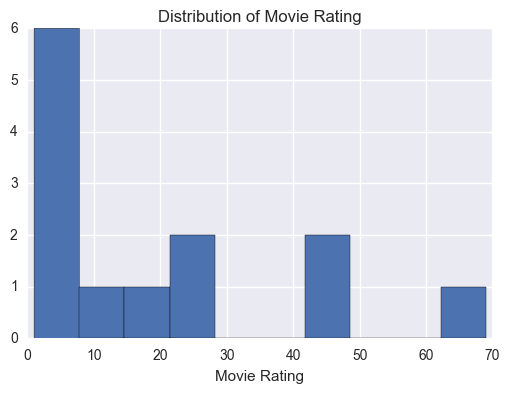

In [1813]:
#finding histogram for rating
print top250['rating'].median()
top250['rating'].value_counts().sort_index().hist()
plt.title('Distribution of Movie Rating')
plt.xlabel('Movie Rating');

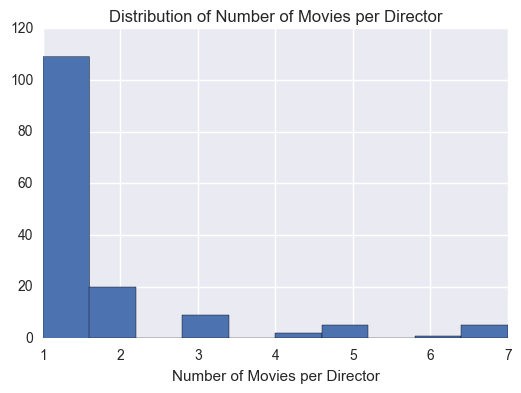

In [1815]:
#count of movies by director in top250
movie_director['count'].hist()
plt.title('Distribution of Number of Movies per Director')
plt.xlabel('Number of Movies per Director');

128.84


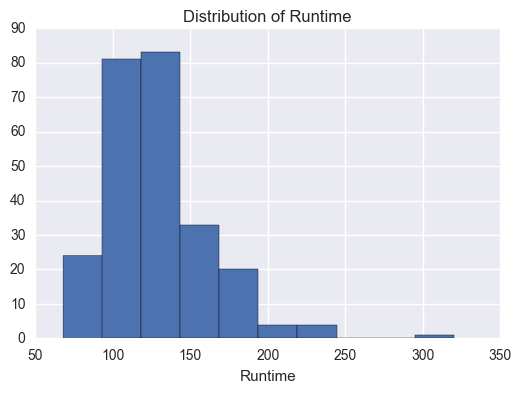

In [1819]:
#distribution of runtime
print top250['runtime'].mean()
top250['runtime'].hist()
plt.title('Distribution of Runtime')
plt.xlabel('Runtime');

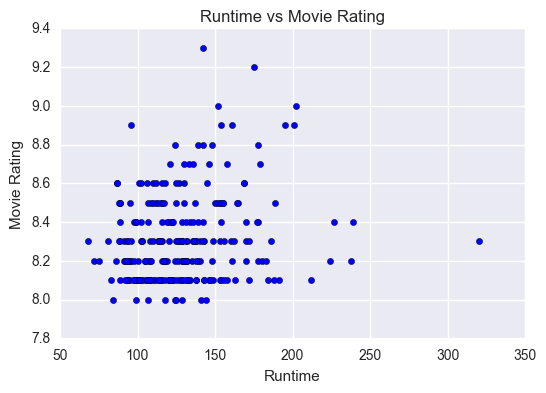

In [1817]:
#runtime vs rating
plt.scatter(x='runtime',y='rating',data=top250)
plt.title('Runtime vs Movie Rating')
plt.xlabel('Runtime')
plt.ylabel('Movie Rating');

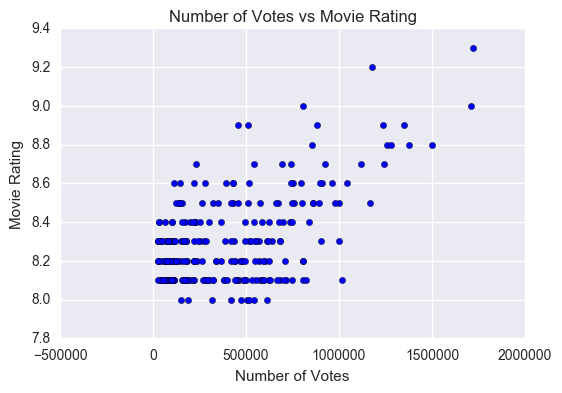

In [1818]:
#number of votes vs rating
plt.scatter(x='num_votes',y='rating',data=top250)
plt.title('Number of Votes vs Movie Rating')
plt.xlabel('Number of Votes')
plt.ylabel('Movie Rating');

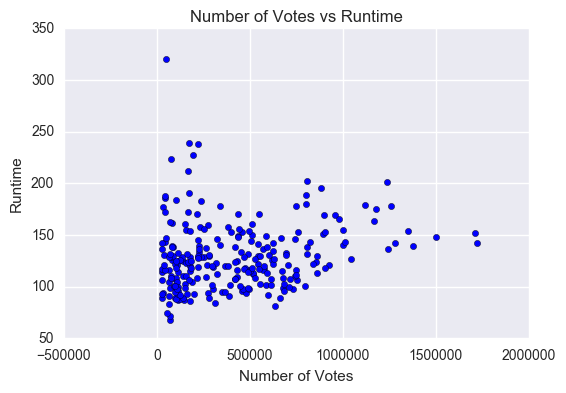

In [1820]:
# number of votes vs runtime
plt.scatter(x='num_votes',y='runtime',data=top250)
plt.title('Number of Votes vs Runtime')
plt.xlabel('Number of Votes')
plt.ylabel('Runtime');

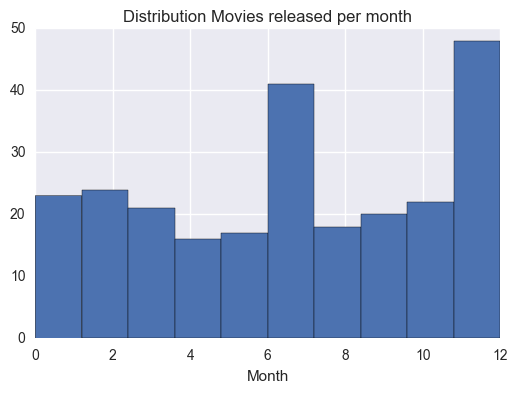

In [1821]:
#plotting histograms of month released
plt.hist(x='release_month',data=top250)
plt.title('Distribution Movies released per month')
plt.xlabel('Month');

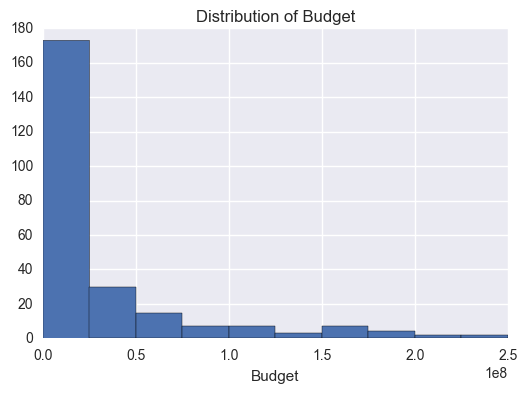

In [1823]:
#distribution of budget - shows it is skewed
top250['Budget'].hist()
plt.title('Distribution of Budget')
plt.xlabel('Budget');

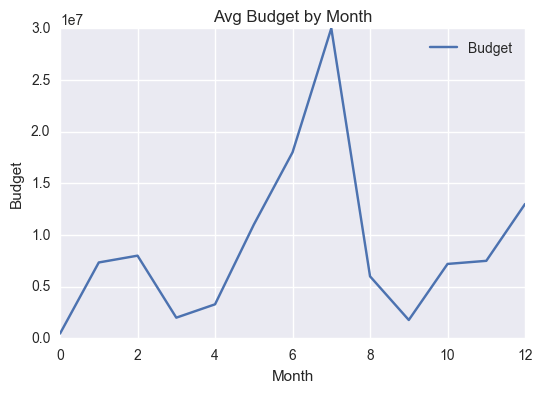

In [1824]:
#average budget vs month released
budget_month = top250.groupby('release_month')['Budget'].median().to_frame()
budget_month.reset_index(inplace = True)
budget_month.plot(x='release_month',y='Budget')
plt.title('Avg Budget by Month')
plt.xlabel('Month')
plt.ylabel('Budget');

### Tree-Based Models

#### Using Cross-Val-Score to determine best model

In [1848]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)


In [1896]:
dt = DecisionTreeClassifier(random_state=77,class_weight='balanced')
rf = RandomForestClassifier(n_jobs=-1,random_state=77,class_weight='balanced')
et = ExtraTreesClassifier(n_jobs=-1,random_state=77,class_weight='balanced')

In [1897]:
cvs_dt = cross_val_score(dt,X_test,y_test,cv=5)
cvs_rf = cross_val_score(rf,X_test,y_test,cv=5)
cvs_et = cross_val_score(et,X_test,y_test,cv=5)

print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", cvs_dt.mean().round(3), cvs_dt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", cvs_rf.mean().round(3), cvs_rf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", cvs_et.mean().round(3), cvs_et.std().round(3)))

Decision Tree Score:	0.552 ± 0.079
Random Forest Score:	0.539 ± 0.105
Extra Trees Score:	0.513 ± 0.027


From the Cross-Val-Score, Decision Tree yielded the best model.

### Decision Tree Model

In [1898]:
dt_model = dt.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_model.feature_importances_
dt_importance = pd.DataFrame(dt_model.feature_importances_,index=X.columns,columns=['dt_importance'])
dt_importance.sort_values('dt_importance',ascending = False)

,dt_importance
Budget,0.332418
runtime,0.252686
mid_actors,0.086358
top_director,0.080328
Oscar_nom,0.072659
Oscar_win,0.063554
season_Winter,0.047174
season_Summer,0.025968
top_actors,0.023963
season_Fall,0.014892


In [1899]:
print "Accuracy Score is:",accuracy_score(y_test,dt_pred)
print "F1 Score is:",f1_score(y_test,dt_pred)
print classification_report(y_test,dt_pred)
pd.DataFrame(confusion_matrix(y_test,dt_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])

Accuracy Score is: 0.675675675676
F1 Score is: 0.714285714286
             precision    recall  f1-score   support

          0       0.67      0.59      0.62        34
          1       0.68      0.75      0.71        40

avg / total       0.67      0.68      0.67        74



,pred_not_rating_high,pred_rating_high
not_rating_high,20,14
rating_high,10,30


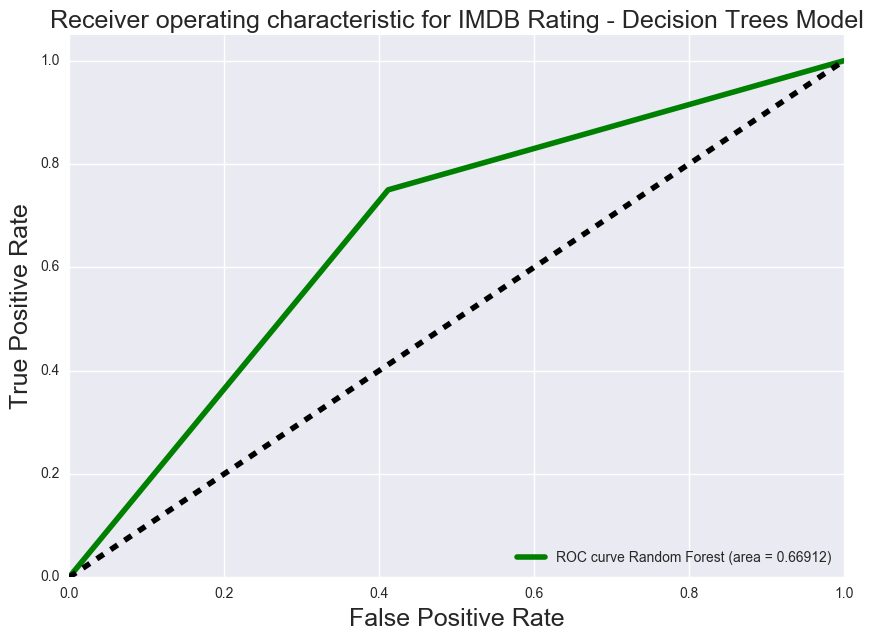

In [1905]:
y_pp_dt = pd.DataFrame(dt_model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve

FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_dt['class_1_pp'])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Random Forest (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating - Decision Trees Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Random Forest - Model

In [1894]:
rf_model = rf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_model.feature_importances_
rf_importance = pd.DataFrame(rf_model.feature_importances_,index=X.columns,columns=['rf_importance'])
rf_importance.sort_values('rf_importance',ascending = False)

,rf_importance
Budget,0.245496
runtime,0.215534
Oscar_nom,0.118614
Oscar_win,0.109918
top_director,0.086486
mid_actors,0.061332
top_actors,0.054483
Drama,0.032216
season_Fall,0.030833
season_Summer,0.024423


In [1895]:
print "Accuracy Score is:",accuracy_score(y_test,rf_pred)
print "F1 Score is:",f1_score(y_test,rf_pred)

print classification_report(y_test,rf_pred)
pd.DataFrame(confusion_matrix(y_test,rf_pred),index=['not_rating_high','rating_high'],columns = ['pred_not_rating_high','pred_rating_high'])

Accuracy Score is: 0.581081081081
F1 Score is: 0.607594936709
             precision    recall  f1-score   support

          0       0.54      0.56      0.55        34
          1       0.62      0.60      0.61        40

avg / total       0.58      0.58      0.58        74



,pred_not_rating_high,pred_rating_high
not_rating_high,19,15
rating_high,16,24


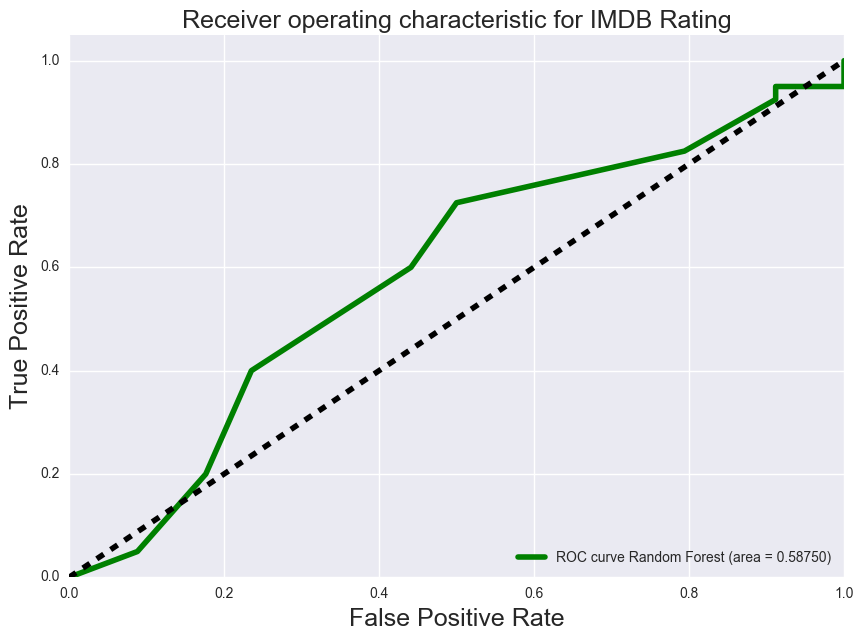

In [1903]:
y_pp_rf = pd.DataFrame(rf_model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve

FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_rf['class_1_pp'])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[10,7])

plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Random Forest (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for IMDB Rating', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Conclusion

This analysis investigated the features of what makes a good movie (high rating). Since the access rights to movies do cost companies like Netflix, it is important that they select movies that their users want to watch, otherwise, they might shift to competitors. 

The analysis here was not robust enough, as more than top250 movies are needed to determine whether the features can predict the movie rating. There are some unobservables such as plot. One can assume that being nominated for awards is a decend indicator, but there are observations of movies that are blockbusters, but have not been nominated or won an Oscar.



The decision tree yielded the cross val score, and thus selected for the model. The precision score was 68%, which means the model was 68% correct for predicting a high movie rating given that it was a high rating. The average weighted of precision and recall is the F1 Score, which yielded 67%.

For random forest model, it performed slightly worse than the decision tree. The precision score was 62% and the F1-Score was 58%. 

Collecting more data should improve this model and thus predict whether a movie will have a high rating. One note to point out is that we need to include which movies are on netflix and other streaming site, as that would increase the number of sources that a movie could be watched. Also ratings might be biased, as it could be only certain type of people would take time to rate a movie.